In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [127]:
df0 = pd.read_csv("/content/spotify_songs_dataset.csv")
df = df0.copy()

In [128]:
df.sample(n=10)

,song_id,song_title,artist,album,genre,release_date,duration,popularity,stream,language,explicit_content,label,composer,producer,collaboration
16239,SP16240,Official audience kid after.,Sarah Stevenson,Yourself.,Hip-Hop,2008-08-07,251.0,34,27475472,English,Yes,Def Jam,Caleb Martin,Sarah Green,NaN
38109,SP38110,Break everyone trade.,Jonathan Mcdonald,Forward.,Country,1996-12-02,267.0,96,61629274,English,No,Sony Music,Brianna Compton,Gabriella Fuller,NaN
26011,SP26012,Grow garden.,Joel Eaton,Top.,Pop,2000-08-01,141.0,91,9495014,NaN,Yes,Warner Music,Joshua Porter,Erin Sanders,NaN
869,SP0870,Charge here.,Michael Jennings,Executive include.,Electronic,2008-02-22,143.0,12,8201901,English,No,Def Jam,Sandra Larson,Kathryn Hunter,Andrew Jones
26845,SP26846,Bag political nearly tree.,Jenna Arnold,Beyond modern.,Electronic,2018-10-27,286.0,20,27565724,NaN,No,Indie,Michele Macdonald,Angela Lopez,NaN
36991,SP36992,Information much.,Darius Rice,Another.,Pop,1995-08-08,NaN,98,13912102,English,No,Universal Music,Denise Jones,Marcus Rodriguez,NaN
33028,SP33029,Sense happy.,Yolanda Hooper,Build.,Pop,2001-06-29,NaN,16,41440441,English,Yes,Indie,Jessica Jacobson,George Tucker,NaN
6644,SP6645,Throw hear material.,Frank Brooks,How international.,Hip-Hop,2019-12-21,269.0,62,91721728,Italian,No,Universal Music,Ashley Campbell,Joseph Sparks DVM,NaN
16227,SP16228,West member significant.,Jason Hines,Television.,Hip-Hop,2007-06-23,272.0,42,27369180,English,No,Atlantic Records,Sabrina Stone,Darren Wright,NaN
44809,SP44810,Woman later.,Sean Brown,Prevent.,Electronic,1999-04-27,219.0,28,78186823,English,Yes,Sony Music,Bradley Washington,Stephen Mccullough,Thomas Griffith


In [129]:
df.shape

(50000, 15)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           50000 non-null  object 
 1   song_title        50000 non-null  object 
 2   artist            50000 non-null  object 
 3   album             50000 non-null  object 
 4   genre             50000 non-null  object 
 5   release_date      50000 non-null  object 
 6   duration          45000 non-null  float64
 7   popularity        50000 non-null  int64  
 8   stream            50000 non-null  int64  
 9   language          47500 non-null  object 
 10  explicit_content  50000 non-null  object 
 11  label             50000 non-null  object 
 12  composer          50000 non-null  object 
 13  producer          50000 non-null  object 
 14  collaboration     15000 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 5.7+ MB


In [131]:
df.duplicated().sum()

np.int64(0)

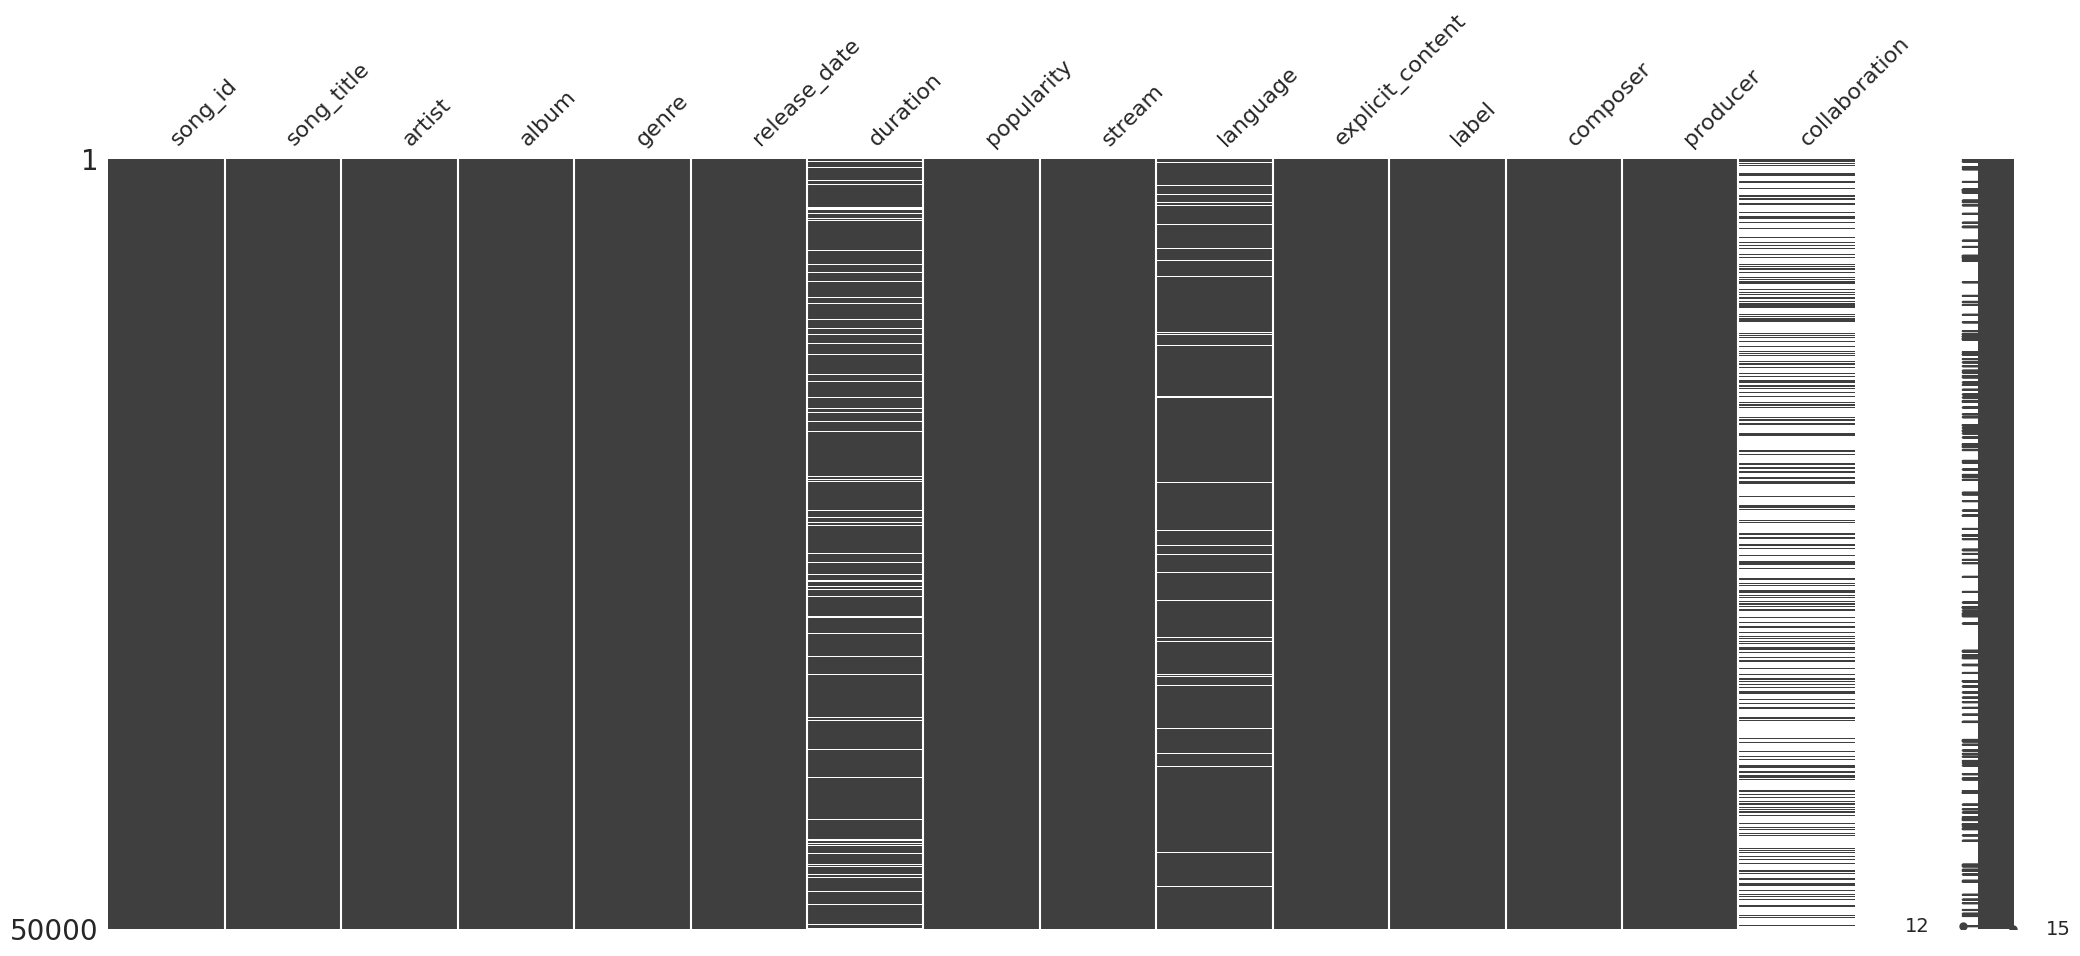

In [132]:
msno.matrix(df);

In [133]:
df["song_title"] = df["song_title"].str.title()
df.song_title.nunique()

46396

In [134]:
df["album"] = df["album"].str.title()

In [135]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

max_year = df['release_date'].dt.year.max()

print(f"O maior ano: {max_year}")

O maior ano: 2024


In [136]:
min_year = df['release_date'].dt.year.min()
print(f"O menor ano é: {min_year}")

O menor ano é: 1994


In [137]:
df.groupby("genre")["duration"].mean().round(0)

,duration
genre,
Classical,239.0
Country,239.0
Electronic,240.0
Folk,240.0
Hip-Hop,240.0
Jazz,240.0
Pop,239.0
R&B,240.0
Reggae,241.0


In [138]:
df['duration'] = df.groupby('genre')['duration'].apply(lambda x: x.fillna(x.mean().round(0))).reset_index(level=0, drop=True)

In [139]:
df['language'] = df.groupby('genre')['language'].apply(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
).reset_index(level=0, drop=True)

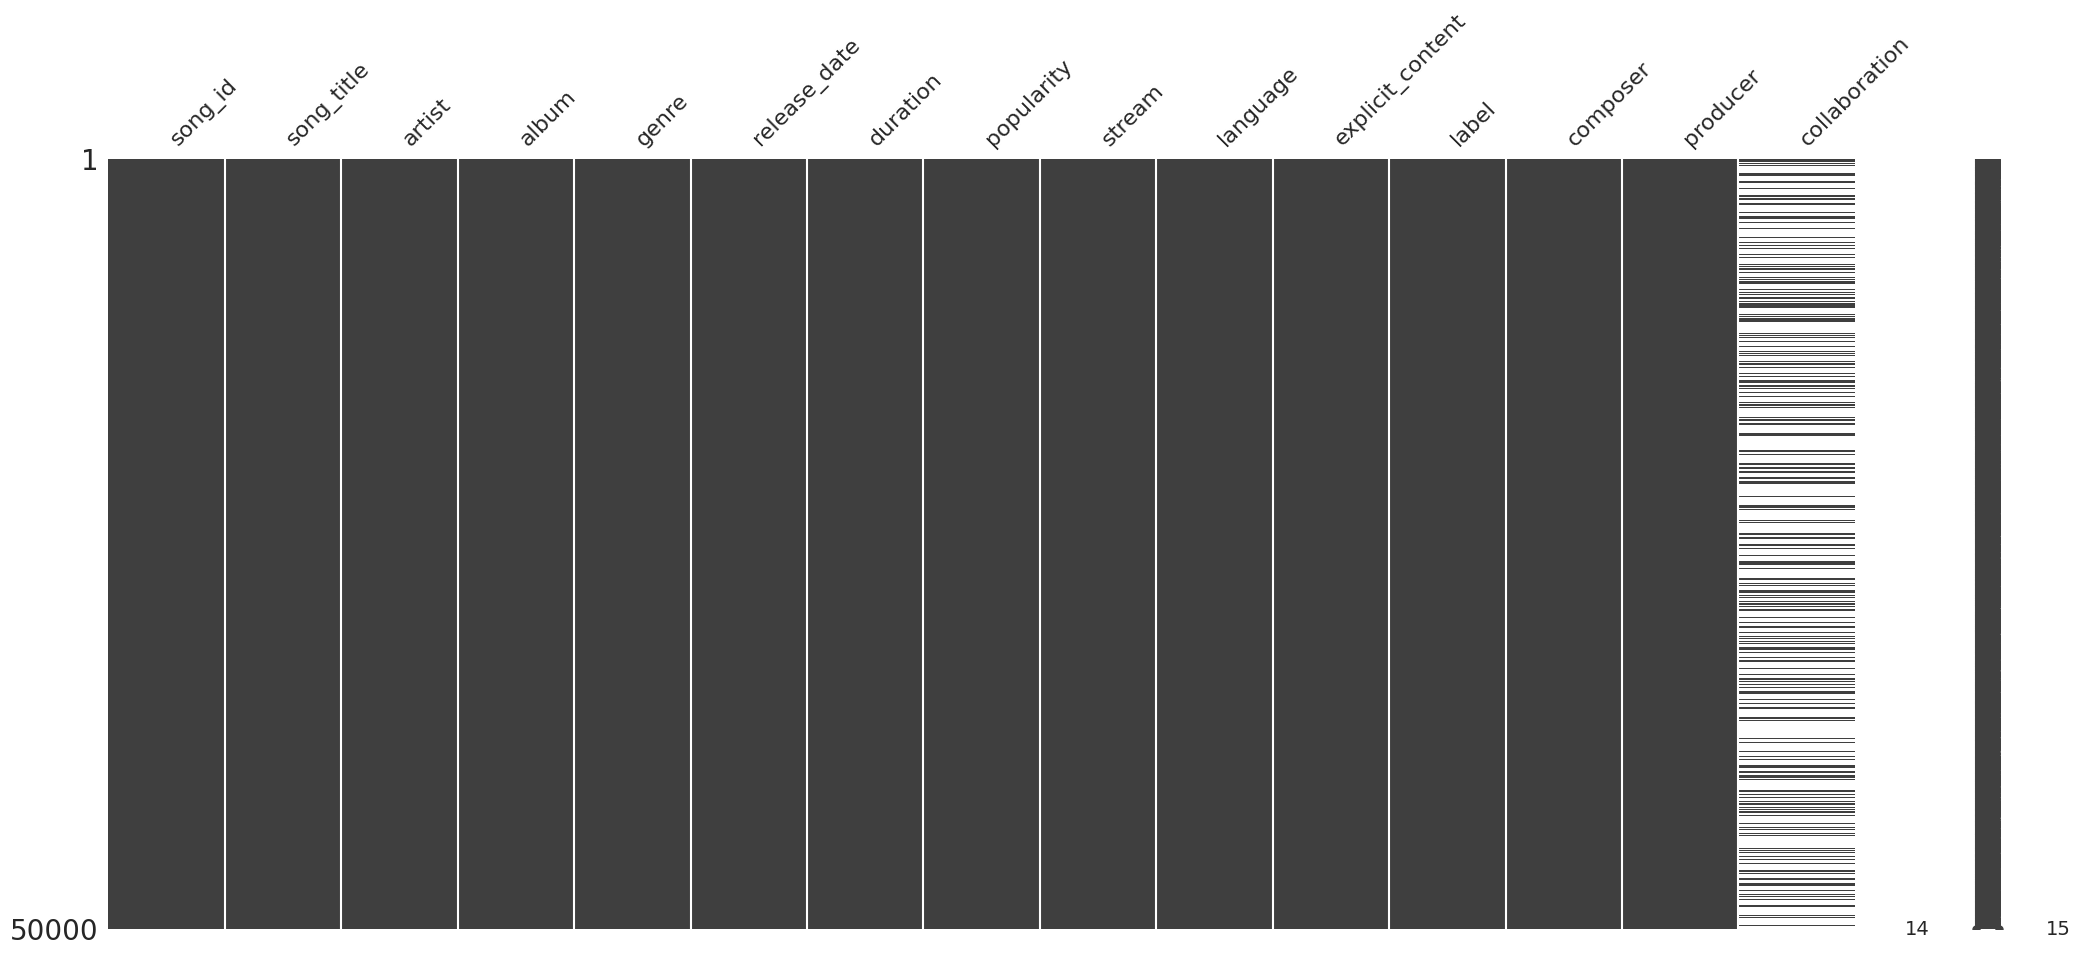

In [140]:
msno.matrix(df);

In [141]:
df.collaboration.isnull().sum()

np.int64(35000)

In [142]:
df = df.drop('collaboration', axis=1)
df.head()

,song_id,song_title,artist,album,genre,release_date,duration,popularity,stream,language,explicit_content,label,composer,producer
0,SP0001,Space Executive Series.,Sydney Clark,What.,Electronic,1997-11-08,282.0,42,35055874,English,Yes,Def Jam,Amy Hatfield,Jeffrey Weaver
1,SP0002,Price Last Painting.,Connor Peters DDS,Nature Politics.,Electronic,2015-05-10,127.0,50,9249527,English,Yes,Universal Music,Jason Gregory,Kenneth White
2,SP0003,Piece.,Anna Keith,Visit.,Pop,2024-07-08,239.0,10,76669110,English,Yes,Universal Music,Rachel Lopez,Jason Barnes
3,SP0004,Power Industry Your.,Zachary Simpson,Behavior Evening.,Hip-Hop,2022-08-15,214.0,86,34732016,English,No,Sony Music,Thomas Li,Mrs. Becky Palmer
4,SP0005,Food Animal Second.,Christopher Mcgee,Front.,Pop,2023-03-05,273.0,63,96649372,English,Yes,Def Jam,Adam Wagner,Beverly Baker


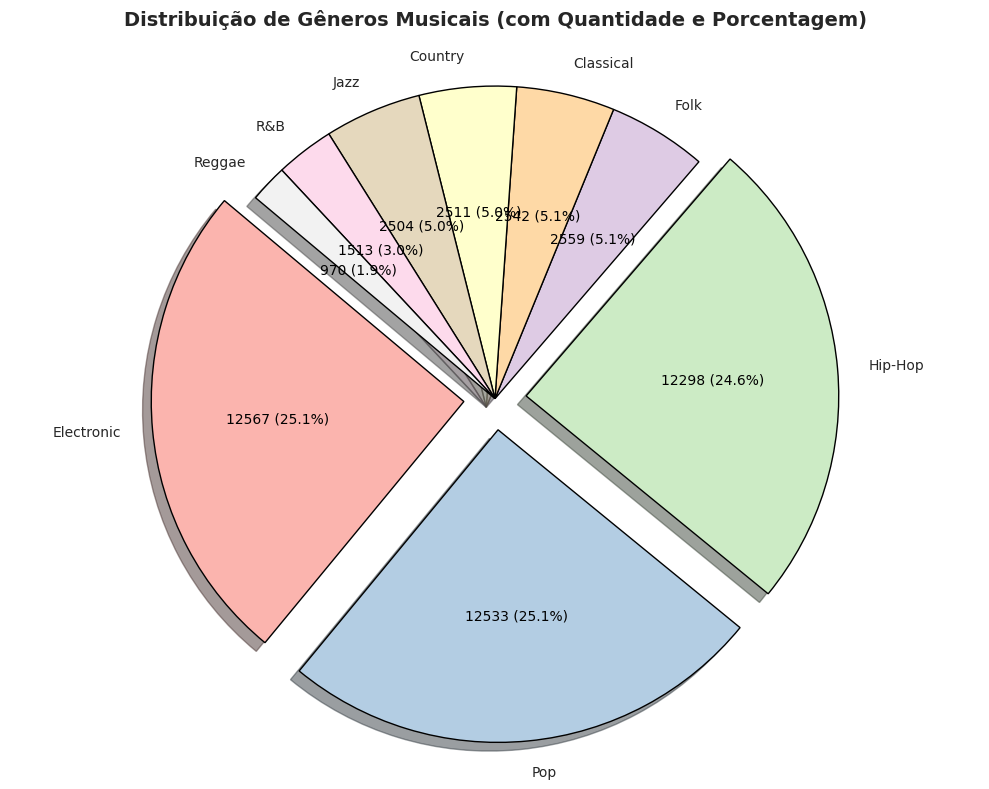

In [143]:
genre_counts = df['genre'].value_counts()
labels = genre_counts.index
sizes = genre_counts.values

colors = plt.cm.Pastel1(np.linspace(0, 1, len(labels)))

explode = [0.1 if i < 3 else 0 for i in range(len(labels))]

plt.figure(figsize=(10, 8))

patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: f'{int(pct/100.*np.sum(sizes))} ({pct:.1f}%)',
    colors=colors,
    shadow=True,
    startangle=140,
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')

plt.title('Distribuição de Gêneros Musicais (com Quantidade e Porcentagem)', fontsize=14, weight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

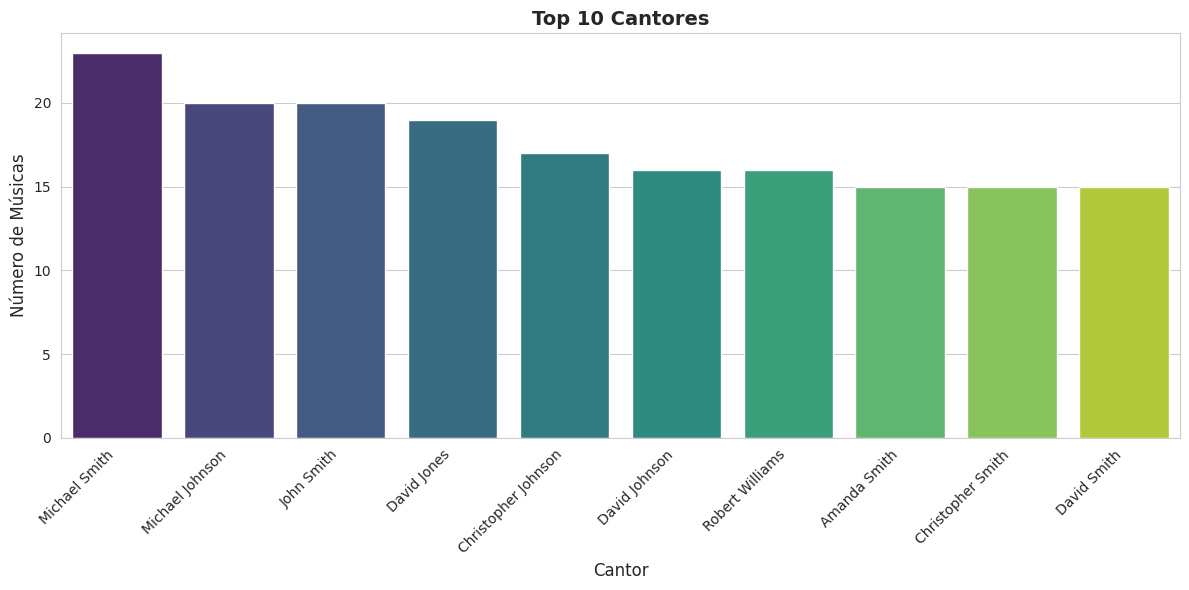

In [144]:
top_10_artists = df['artist'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_artists.index, y=top_10_artists.values, palette='viridis')
plt.title('Top 10 Cantores', fontsize=14, weight='bold')
plt.xlabel('Cantor', fontsize=12)
plt.ylabel('Número de Músicas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

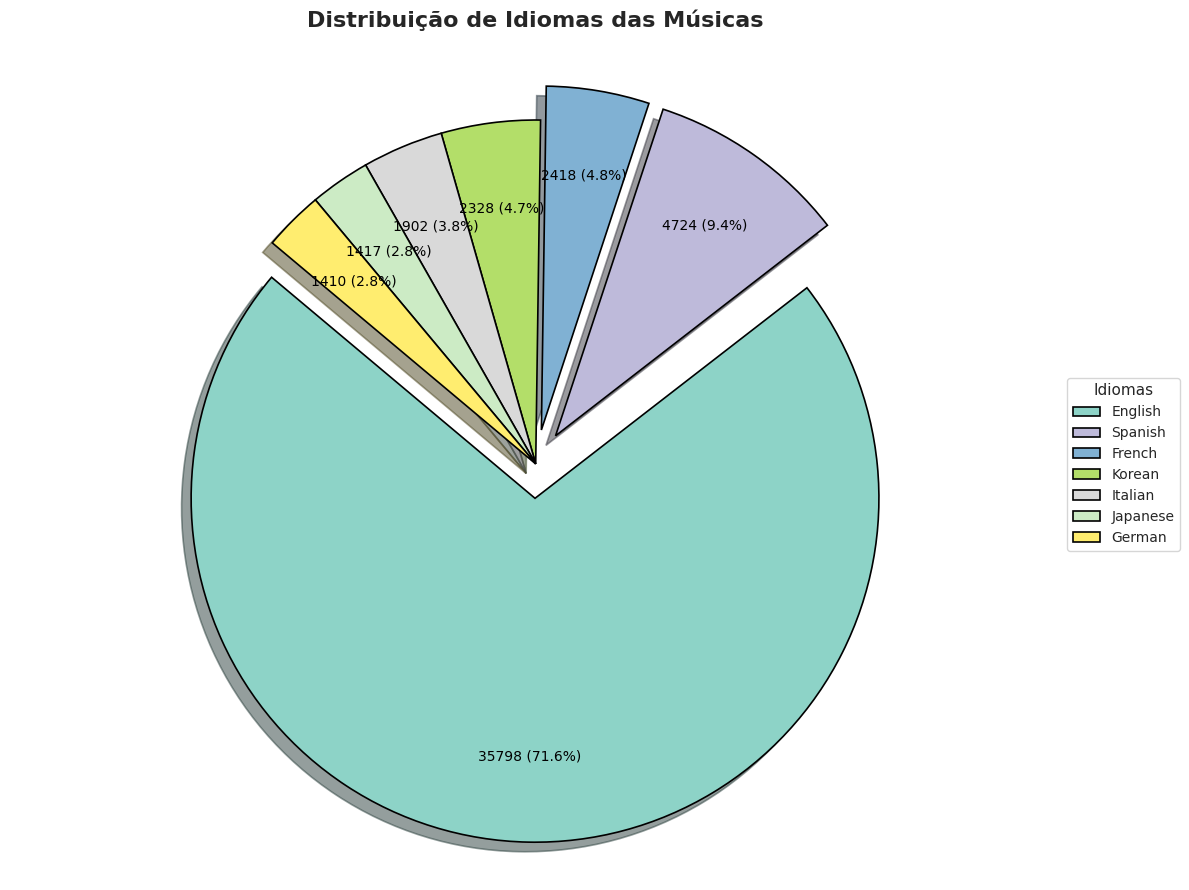

In [145]:
language_counts = df['language'].value_counts()
labels_lang = language_counts.index
sizes_lang = language_counts.values

colors_lang = plt.cm.Set3(np.linspace(0, 1, len(labels_lang)))

explode_lang = [0.1 if i < 3 else 0 for i in range(len(labels_lang))]

plt.figure(figsize=(12, 9))

def custom_autopct(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return f'{absolute} ({pct:.1f}%)' if pct > 2 else ''

patches_lang, texts_lang, autotexts_lang = plt.pie(
    sizes_lang,
    labels=None,
    autopct=lambda pct: custom_autopct(pct, sizes_lang),
    colors=colors_lang,
    shadow=True,
    startangle=140,
    explode=explode_lang,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.2},
    pctdistance=0.75
)

for autotext in autotexts_lang:
    autotext.set_fontsize(10)
    autotext.set_color('black')

plt.legend(
    patches_lang,
    labels_lang,
    title="Idiomas",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=11
)

plt.title('Distribuição de Idiomas das Músicas', fontsize=16, weight='bold', pad=15)
plt.axis('equal')
plt.tight_layout()
plt.show()


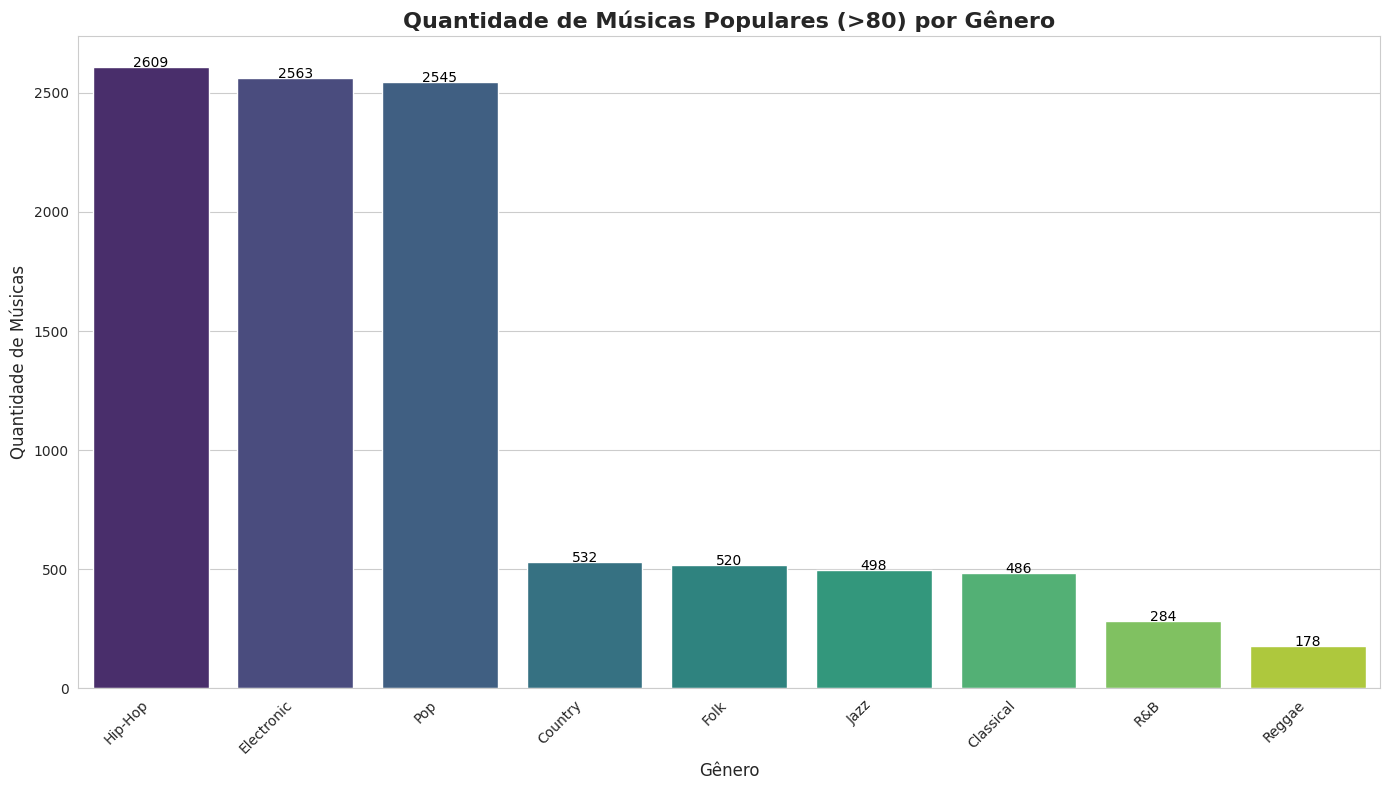

In [146]:
df_popular = df[df['popularity'] > 80]

genre_counts_popular = df_popular['genre'].value_counts().reset_index()
genre_counts_popular.columns = ['genre', 'count']

plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='genre', y='count', data=genre_counts_popular, palette='viridis')

for index, row in genre_counts_popular.iterrows():
    barplot.text(index, row['count'], row['count'], color='black', ha="center")

plt.title('Quantidade de Músicas Populares (>80) por Gênero', fontsize=16, weight='bold')
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Quantidade de Músicas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


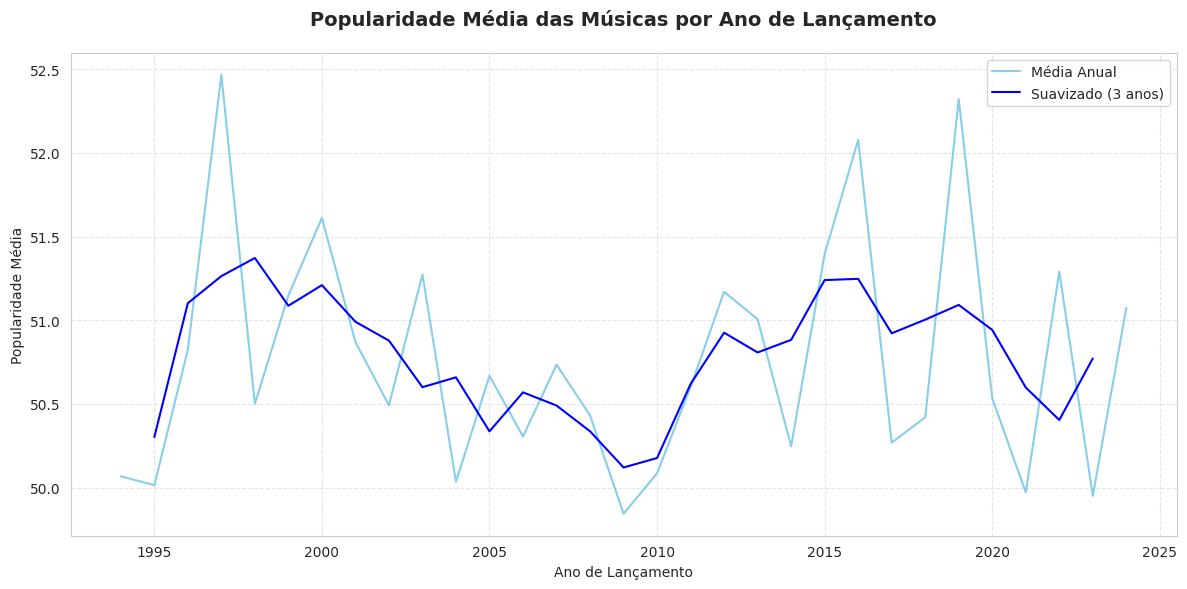

In [147]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['release_year'] = df['release_date'].dt.year

df_yearly = df[df['release_year'].between(1950, 2025)]

yearly_popularity = df_yearly.groupby('release_year')['popularity'].mean().reset_index()

yearly_popularity['popularity_smooth'] = yearly_popularity['popularity'].rolling(window=3, center=True).mean()

plt.figure(figsize=(12,6))
sns.lineplot(x='release_year', y='popularity', data=yearly_popularity, label='Média Anual', color='skyblue')
sns.lineplot(x='release_year', y='popularity_smooth', data=yearly_popularity, label='Suavizado (3 anos)', color='blue')

plt.title('Popularidade Média das Músicas por Ano de Lançamento', fontsize=14, weight='bold', pad=20)
plt.xlabel('Ano de Lançamento')
plt.ylabel('Popularidade Média')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Top 10 Álbuns por Stream:
                 album              artist     stream
44851           Today.     Robert Williams  177448826
48051           While.        Thomas Davis  148377336
12024           Dream.        Joshua Smith  116527102
22541            Late.       Michael Brown  112238234
29821             Our.       Michael Clark  100385797
38644         Similar.  Catherine Anderson   99999128
5175          Billion.        Selena Perez   99998468
2570   Appear Trouble.        Thomas Roach   99996451
44229      Those Task.    Jason Strickland   99993859
12285     Each Season.      Monica Stevens   99992156


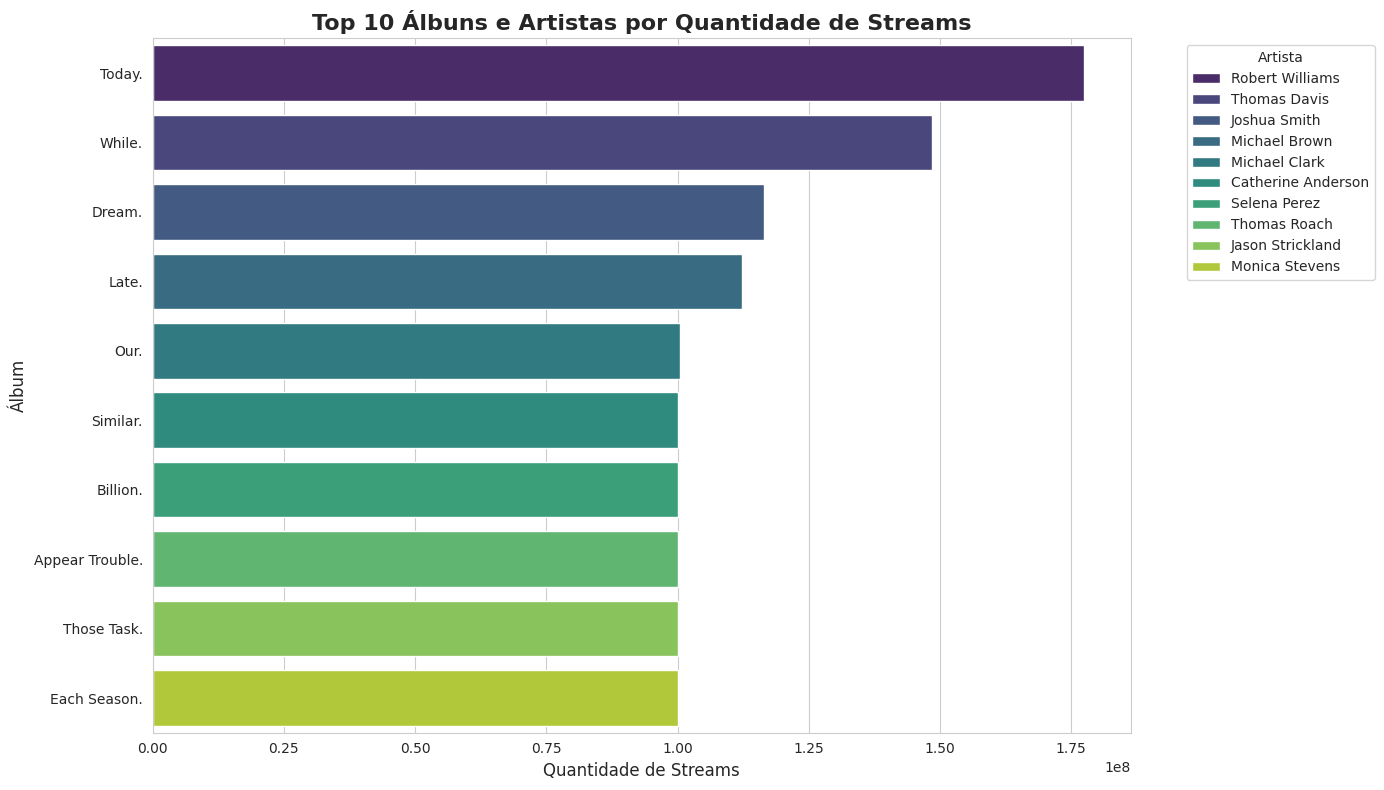

In [148]:
album_streams = df.groupby(['album', 'artist'])['stream'].sum().reset_index()

top_10_albums_by_streams = album_streams.sort_values(by='stream', ascending=False).head(10)

print("Top 10 Álbuns por Stream:")
print(top_10_albums_by_streams)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_10_albums_by_streams,
    x='stream',
    y='album',
    hue='artist',
    dodge=False,
    palette='viridis'
)

plt.title('Top 10 Álbuns e Artistas por Quantidade de Streams', fontsize=16, weight='bold')
plt.xlabel('Quantidade de Streams', fontsize=12)
plt.ylabel('Álbum', fontsize=12)
plt.legend(title='Artista', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


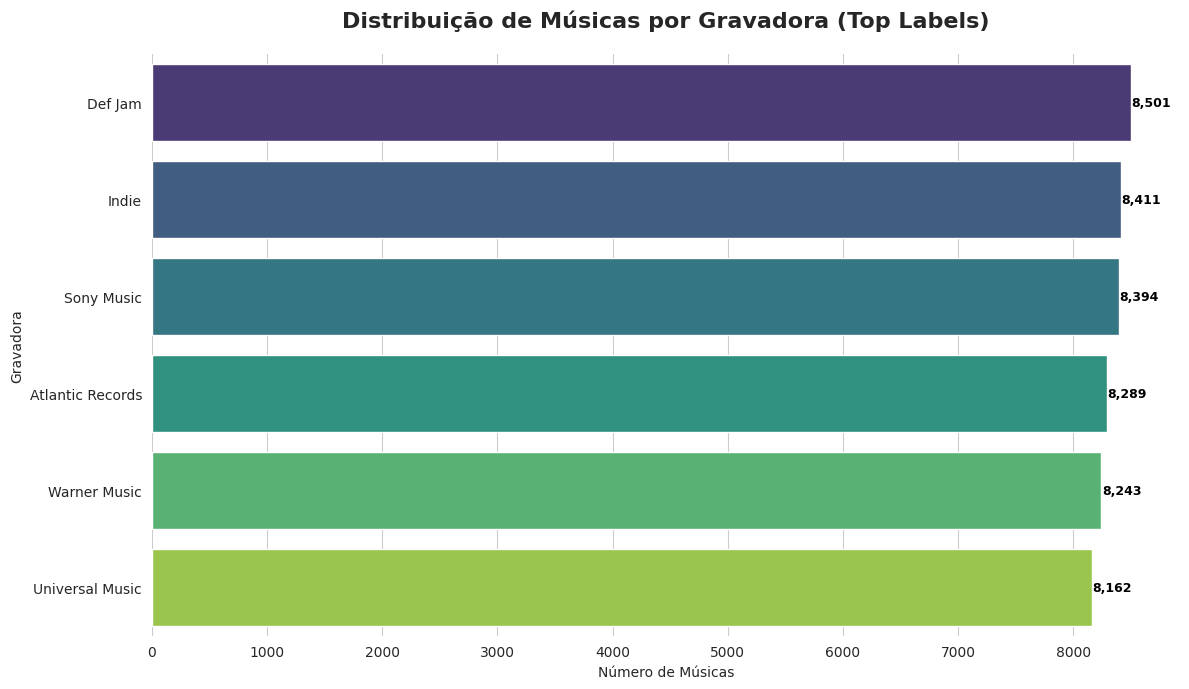

In [149]:
label_count = df.label.value_counts()
label_count_sorted = label_count.sort_values(ascending=False)[:15]

colors = sns.color_palette("viridis", len(label_count_sorted))

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.barplot(
    x=label_count_sorted.values,
    y=label_count_sorted.index,
    palette=colors
)

for i, v in enumerate(label_count_sorted.values):
    ax.text(v + 5, i, f'{v:,}', color='black', va='center', fontsize=9, weight='bold')

plt.title('Distribuição de Músicas por Gravadora (Top Labels)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Número de Músicas')
plt.ylabel('Gravadora')

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


In [150]:
df['release_date'] = pd.to_datetime(df['release_date'])

            popularity        stream  count
genre                                      
Country      51.661888  5.046560e+07   2511
Folk         51.467370  5.048961e+07   2559
Hip-Hop      50.918117  5.021347e+07  12298
Electronic   50.853517  5.021413e+07  12568
Pop          50.684059  4.991478e+07  12534
Jazz         50.431310  4.969095e+07   2504
R&B          50.335096  5.097805e+07   1513
Reggae       49.954686  5.141851e+07    971
Classical    49.649489  5.032964e+07   2542


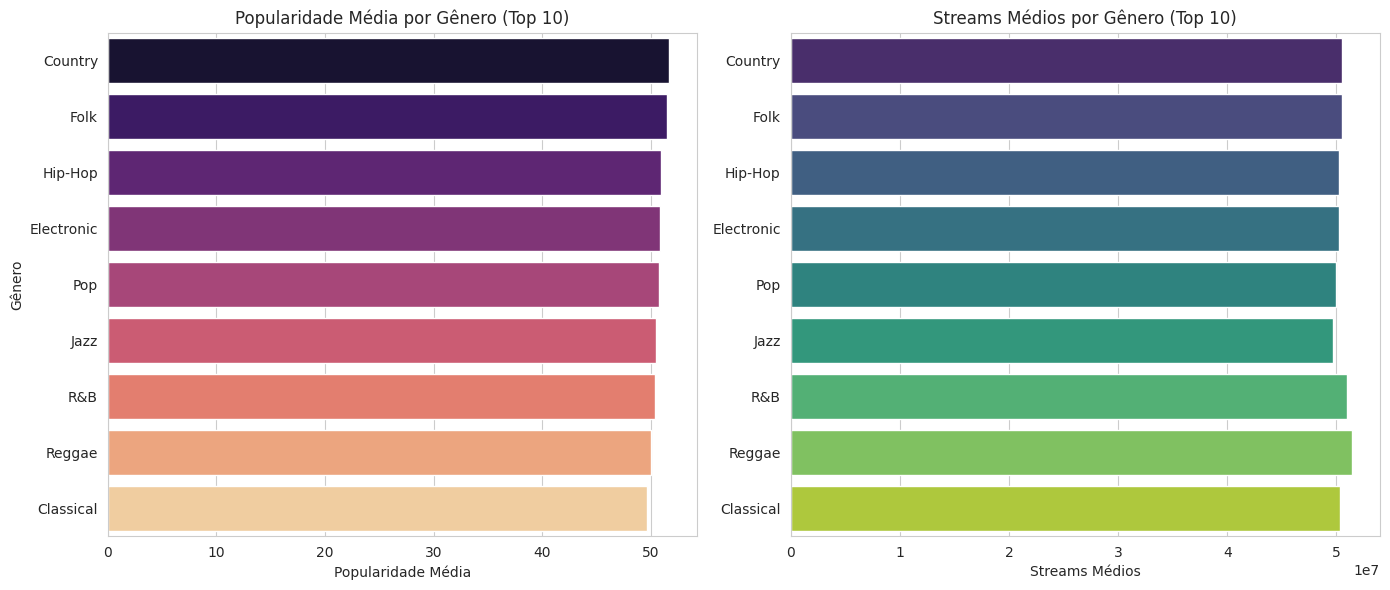

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_stats = df.groupby('genre').agg({
    'popularity': 'mean',
    'stream': 'mean',
    'song_id': 'count'
}).rename(columns={'song_id': 'count'}).sort_values(by='popularity', ascending=False)

print(genre_stats.head(10))

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.barplot(x=genre_stats.head(10).popularity, y=genre_stats.head(10).index, palette='magma')
plt.title('Popularidade Média por Gênero (Top 10)')
plt.xlabel('Popularidade Média')
plt.ylabel('Gênero')

plt.subplot(1,2,2)
sns.barplot(x=genre_stats.head(10).stream, y=genre_stats.head(10).index, palette='viridis')
plt.title('Streams Médios por Gênero (Top 10)')
plt.xlabel('Streams Médios')
plt.ylabel('')

plt.tight_layout()
plt.show()


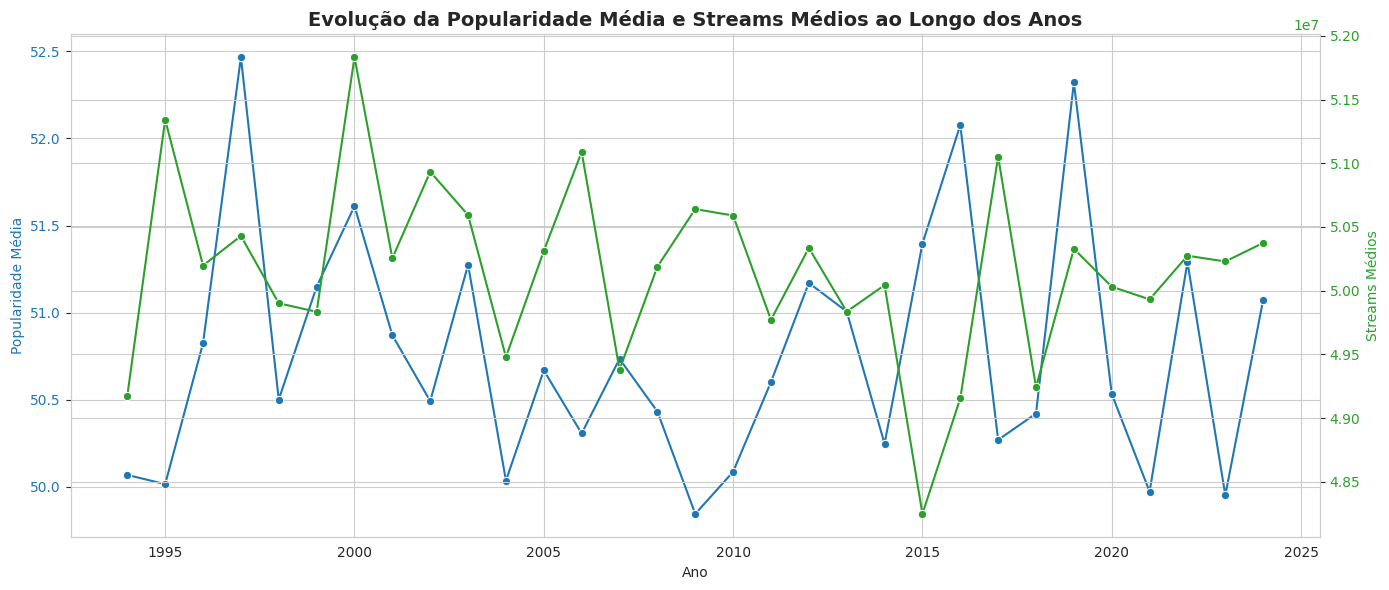

In [161]:
fig, ax1 = plt.subplots(figsize=(14,6))

# Primeiro eixo Y (Popularidade)
color = 'tab:blue'
ax1.set_xlabel('Ano')
ax1.set_ylabel('Popularidade Média', color=color)
sns.lineplot(data=year_stats, x='year', y='popularity', marker='o', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Segundo eixo Y (Streams)
ax2 = ax1.twinx()  # Compartilha o eixo X
color = 'tab:green'
ax2.set_ylabel('Streams Médios', color=color)
sns.lineplot(data=year_stats, x='year', y='stream', marker='o', ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evolução da Popularidade Média e Streams Médios ao Longo dos Anos', fontsize=14, weight='bold')
fig.tight_layout()
plt.show()



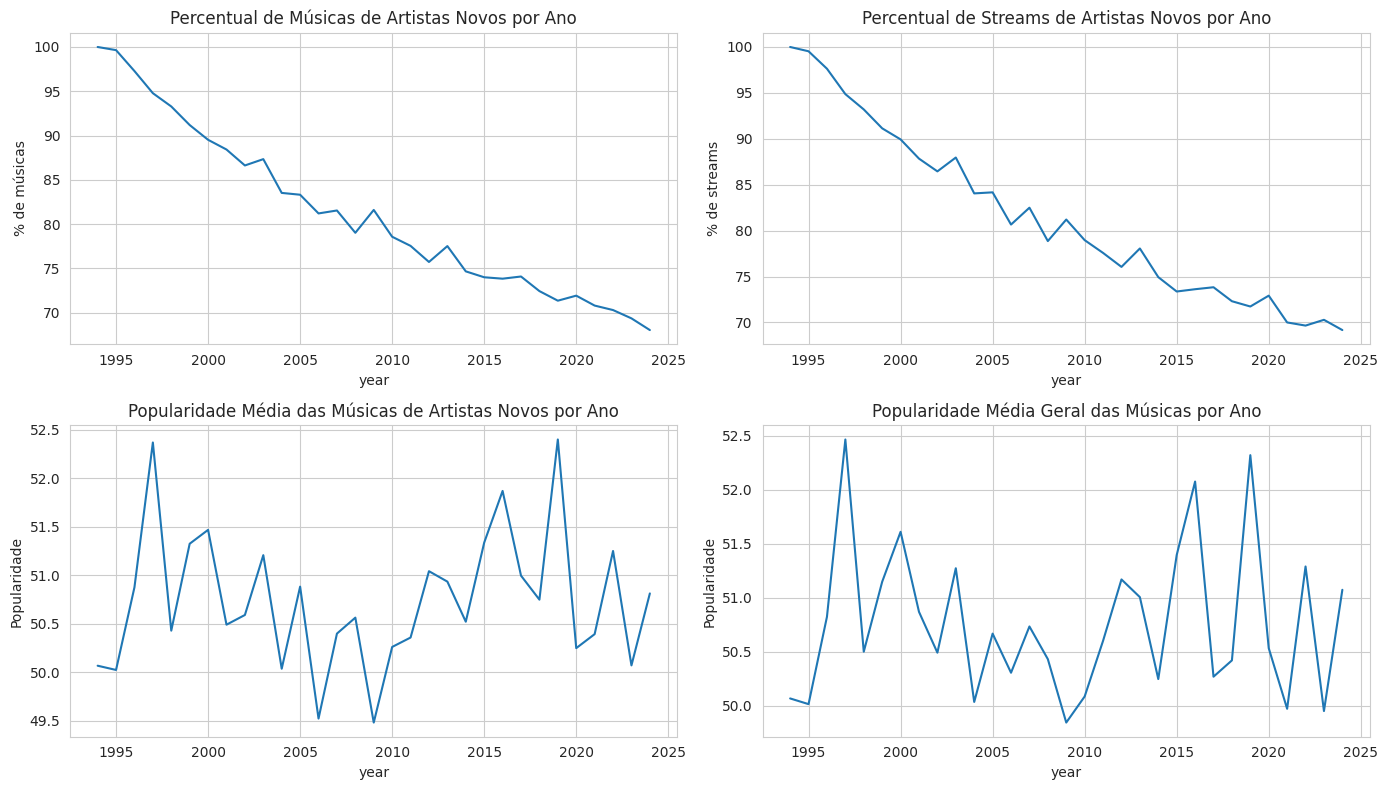

In [153]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date'])
df['year'] = df['release_date'].dt.year

first_appearance = df.groupby('artist')['year'].min().reset_index()
first_appearance.columns = ['artist', 'first_year']

df = df.merge(first_appearance, on='artist')

df['is_new_artist'] = df['year'] == df['first_year']

yearly_stats = df.groupby('year').agg(
    total_songs=('song_id', 'count'),
    new_artist_songs=('is_new_artist', 'sum'),
    total_streams=('stream', 'sum'),
    new_artist_streams=('stream', lambda x: x[df.loc[x.index, 'is_new_artist']].sum()),
    avg_popularity=('popularity', 'mean'),
    new_artist_avg_popularity=('popularity', lambda x: x[df.loc[x.index, 'is_new_artist']].mean())
).reset_index()

yearly_stats['pct_new_artist_songs'] = yearly_stats['new_artist_songs'] / yearly_stats['total_songs'] * 100
yearly_stats['pct_new_artist_streams'] = yearly_stats['new_artist_streams'] / yearly_stats['total_streams'] * 100

plt.figure(figsize=(14, 8))

plt.subplot(2,2,1)
sns.lineplot(data=yearly_stats, x='year', y='pct_new_artist_songs')
plt.title('Percentual de Músicas de Artistas Novos por Ano')
plt.ylabel('% de músicas')

plt.subplot(2,2,2)
sns.lineplot(data=yearly_stats, x='year', y='pct_new_artist_streams')
plt.title('Percentual de Streams de Artistas Novos por Ano')
plt.ylabel('% de streams')

plt.subplot(2,2,3)
sns.lineplot(data=yearly_stats, x='year', y='new_artist_avg_popularity')
plt.title('Popularidade Média das Músicas de Artistas Novos por Ano')
plt.ylabel('Popularidade')

plt.subplot(2,2,4)
sns.lineplot(data=yearly_stats, x='year', y='avg_popularity')
plt.title('Popularidade Média Geral das Músicas por Ano')
plt.ylabel('Popularidade')

plt.tight_layout()
plt.show()
